In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

# plt.style.use('fast')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 18,9


In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

---

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [3]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

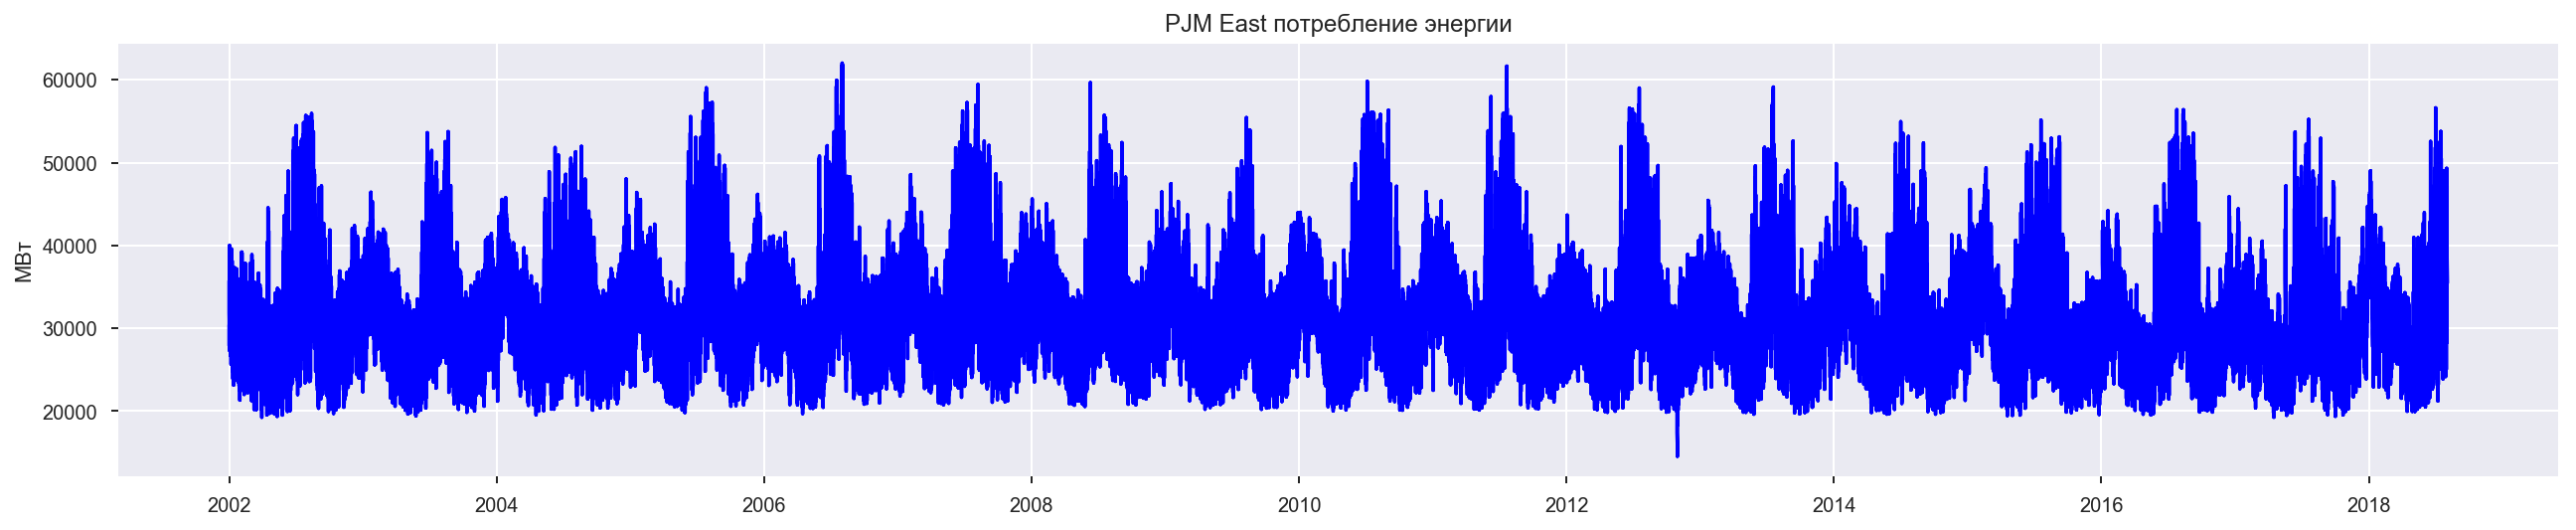

In [5]:
plt.figure( figsize=( 22, 4 ))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [6]:
d_data=data.resample('D').mean()

In [7]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)

In [8]:
data_exp_1 = pd.DataFrame(data = data_exp_1, index = d_data.index)

In [9]:
df= pd.DataFrame(data_exp_1)
df.head()
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)

df.head()

,0,t,t1,t2
Date,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257


In [10]:
train_b, test_b = split_data_b( df, '10-10-2017')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]

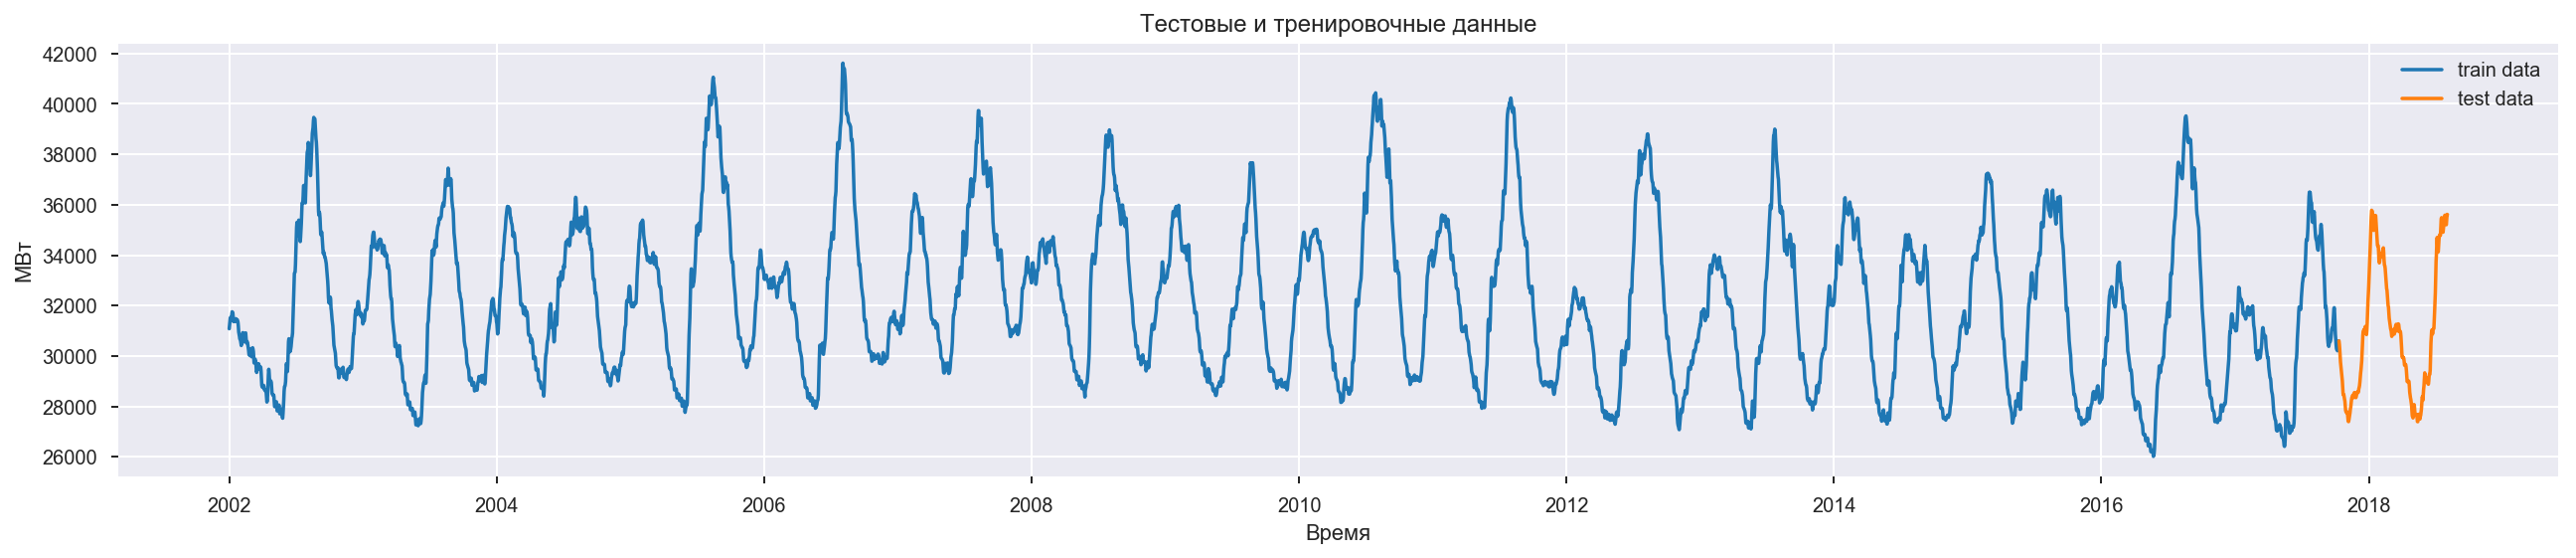

In [11]:
plt.figure( figsize=( 22, 4 ))
plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [12]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

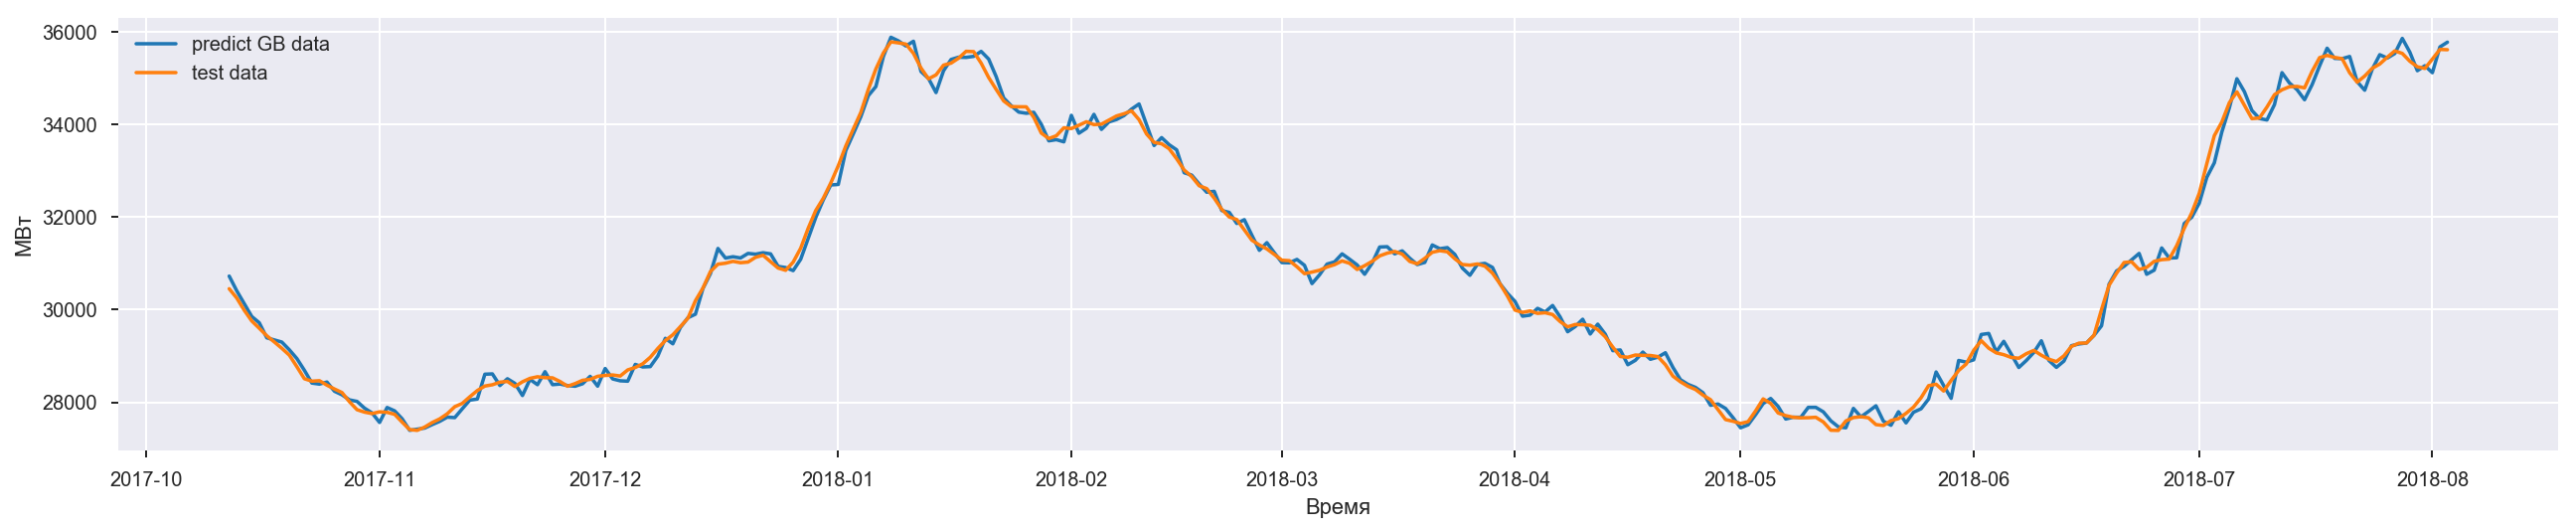

ошибка градиентного бустинга :   0.4181626445389916 %


In [13]:
plt.figure( figsize=( 22, 4 ))

plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
print('ошибка градиентного бустинга :  ', er_g, '%')

In [14]:
h=9
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

In [15]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

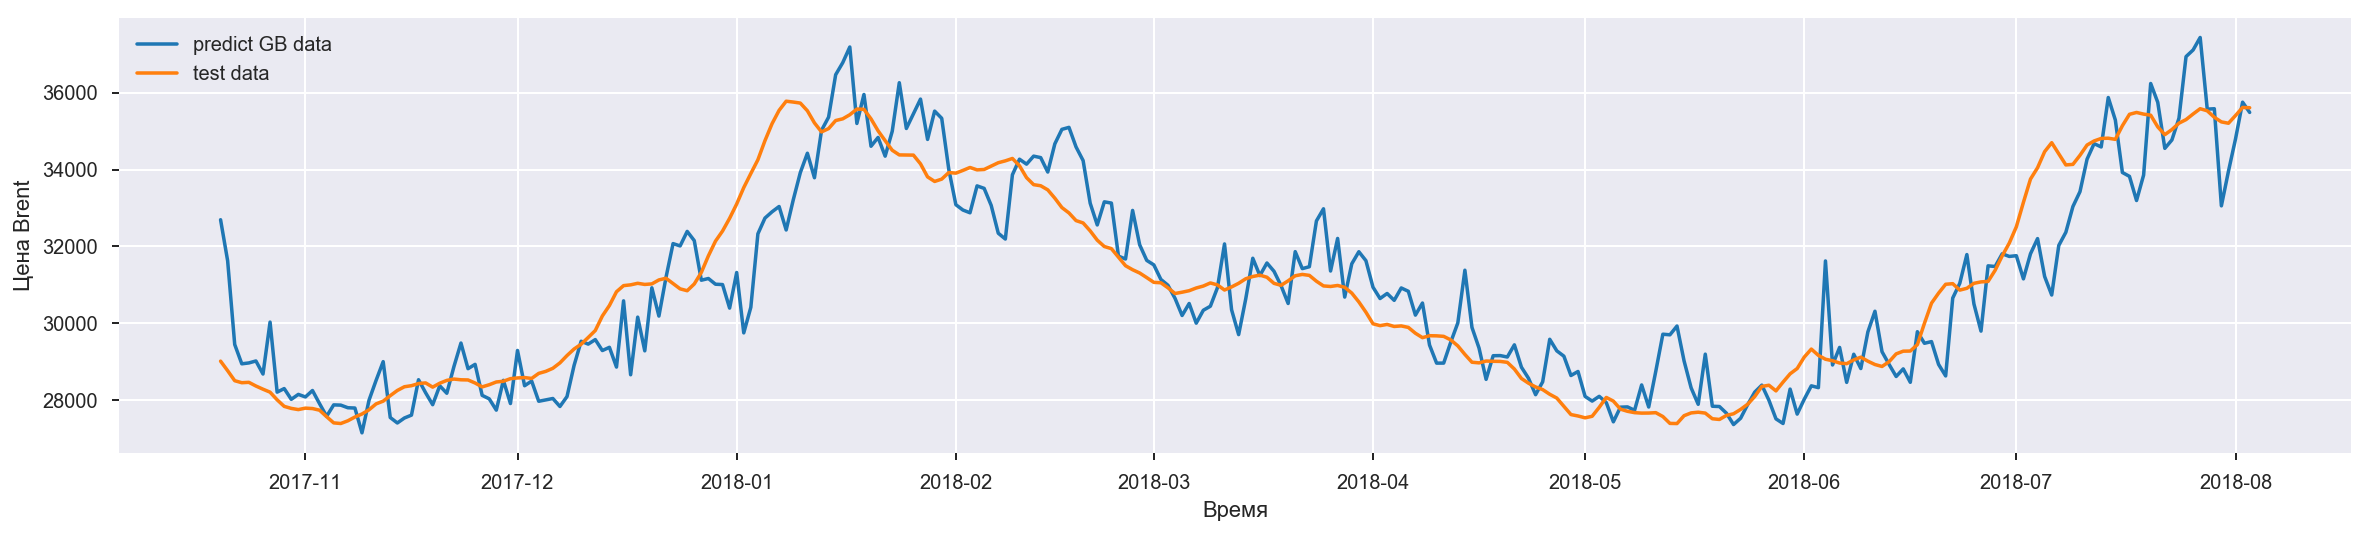

ошибка градиентного бустинга :   2.735220776271653 %


In [16]:
plt.figure( figsize=( 20, 4 ))
plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
print('ошибка градиентного бустинга :  ', er_g, '%')

---

С увеличением глубины прогноза ошибка возрастает